In [1]:
# from read_viva import *
# # import matplotlib.image as mpimg
# # import matplotlib.pyplot as plt

In [2]:
# img_list, box_list = load_viva('/home/cyrano5614/Downloads/detectiondata/train/')

In [3]:
# generate = generate_batch(img_list, box_list, (128, 128), 10, negative=True)


In [4]:
# for i in range(1):
#     batch_imgs, batch_labels = next(generate)
#     batch_visualize(batch_imgs, batch_labels)

In [5]:
from viva.cnn.networks.lenet import LeNet
from viva.cnn.networks.xception_transfer import Xception_Transfer
from viva.bottleneck.extract_bottleneck_features import extract_bottleneck_Xception, extract_features_labels
from read_viva import load_viva, DataGen
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import numpy as np
import argparse
import cv2
from pipeline import pretrained_model

Using TensorFlow backend.


In [6]:
# img_size = (100, 100)
# batch_size = 10
# path = '/media/whatevs/Machine Learning/detectiondata/'
# img_list, box_list = load_viva(path)
# # Splitting into 60/20/20
# train_imgs, test_imgs, train_boxes, test_boxes = train_test_split(
#     img_list, box_list, test_size=0.2)
# train_imgs, valid_imgs, train_boxes, valid_boxes = train_test_split(
#     train_imgs, train_boxes, test_size=0.25)

# # train_gen = 
# bottleneck_model = pretrained_model('Xception', img_size)

# train_generator = generate_batch(train_imgs, train_boxes, img_size=img_size, bottleneck=True, model=bottleneck_model, batch_size=batch_size)
# result = next(train_generator)
# result[0].shape
# print(type(train_generator))
# bottleneck_train_convert = extract_features_labels(bottleneck_model, next(train_generator), batch_size=batch_size)
# valid_generator = generate_batch(
#     valid_imgs, valid_boxes, img_size=img_size, batch_size=batch_size)
# test_generator = generate_batch(
#     test_imgs, test_boxes, img_size=img_size, batch_size=batch_size)

# model_name = 'xception'
# bottleneck_features = extract_bottleneck_Xception(train_generator, valid_generator, test_generator,
#                                                   img_shape=(img_size[0], img_size[1], 3), batch_size=batch_size)
# model = Xception_Transfer.build(bottleneck_features['train']['features'],
#                                 bottleneck_features['train']['labels'])
# bottleneck_features['train']['features']
# bottleneck_train_generator = bottleneck_features
# bottleneck_valid_generator = extract_features_labels(model, valid_generator, batch_size=batch_size)
# bottleneck_test_generator = extract_features_labels(model, test_generator, batch_size=batch_size)



In [7]:
# x, y, z = bottleneck_model.output.shape[1:]
# int(x)


In [8]:
# len(next(train_generator))

In [9]:
# len(np.unique(result[1]))

In [10]:
from sliding_window.sliding_window import slide_window, search_windows, heatmap_windows
from read_viva import *

"""
Data Preprocessing
"""
print('[INFO] Preparing the data...')
train_img_list, train_box_list, test_img_list, test_box_list = load_viva('/media/whatevs/Machine Learning/detectiondata/')
# Splitting into train validation 75/25
train_img_list, valid_img_list, train_box_list, valid_box_list = train_test_split(
    train_img_list, train_box_list, test_size=0.25)
print('[INFO] Loaded {} training images'.format(len(train_img_list)))
print('[INFO] Loaded {} validation images'.format(len(valid_img_list)))
print('[INFO] Loaded {} testing images'.format(len(test_img_list)))

[INFO] Preparing the data...
[INFO] Loaded 4125 training images
[INFO] Loaded 1375 validation images
[INFO] Loaded 5500 testing images


In [11]:
img_size = (128, 128)
batch_size = 20

model = LeNet.build(width=128, height=128, depth=3, classes=2,
                        weights_path='./models/weights.best.sequential_8933.hdf5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 20)      1520      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 20)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 50)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 50)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 50)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
__________

In [12]:
optimizer = SGD(lr=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

In [13]:
test_img = mpimg.imread('./tester3.jpg')
print(test_img.shape)
img = test_img[:,:,:3]
print(img.shape)
img = cv2.resize(img, img_size)
print(img.shape)
img = np.expand_dims(img, axis=0)
print(img.shape)
prediction = model.predict(img)
print(prediction)

(167, 127, 3)
(167, 127, 3)
(128, 128, 3)
(1, 128, 128, 3)
[[ 0.  1.]]


In [14]:
prediction = model.predict(img).flatten()
print(prediction)

[ 0.  1.]


In [15]:
prediction = np.argmax(prediction)
print(prediction)

1


In [16]:
def prediction_method(img):
    img = img.copy()
#     img = cv2.resize(img, (128, 128))
#     img = np.expand_dims(img, axis=0)
    return np.argmax(model.predict(img).flatten()) == 1

In [17]:
from sliding_window.sliding_window import slide_window, search_windows, heatmap_windows

In [18]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

(388, 900, 3)
Starting sliding window (100, 100) from 0, 0 to 900, 388
Finished with 396 windows to slide
396
Starting to search 396 windows
Found window: {((0, 25), (100, 125))}
Found window: {((25, 25), (125, 125))}
Found window: {((125, 25), (225, 125))}
Found window: {((350, 25), (450, 125))}
Found window: {((800, 25), (900, 125))}
Found window: {((0, 50), (100, 150))}
Found window: {((25, 50), (125, 150))}
Found window: {((125, 50), (225, 150))}
Found window: {((350, 50), (450, 150))}
Found window: {((425, 50), (525, 150))}
Found window: {((450, 50), (550, 150))}
Found window: {((575, 50), (675, 150))}
Found window: {((775, 50), (875, 150))}
Found window: {((800, 50), (900, 150))}
Found window: {((0, 75), (100, 175))}
Found window: {((25, 75), (125, 175))}
Found window: {((125, 75), (225, 175))}
Found window: {((225, 75), (325, 175))}
Found window: {((250, 75), (350, 175))}
Found window: {((350, 75), (450, 175))}
Found window: {((425, 75), (525, 175))}
Found window: {((550, 75), (

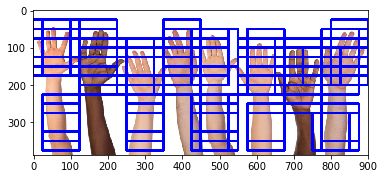

In [19]:
testing_img = mpimg.imread('./tester2.jpg')
print(testing_img.shape)

xy_window = (100, 100)

windows = slide_window(testing_img, xy_window=xy_window)
print(len(windows))

on_windows = search_windows(prediction_method, 
                            img_size=(128, 128), 
                            img=testing_img.copy(), 
                            windows=windows, 
                            xy_window=xy_window)

boxes_img = draw_boxes(testing_img, on_windows)
plt.imshow(boxes_img)
plt.show()
# heat_img, heat_boxes = heatmap_windows(testing_img, on_windows, 1)

# print(heat_boxes)
# plt.imshow(heat_img)
# plt.show()

(388, 900)
Adding heat to box: ((0, 25), (100, 125))
Adding heat to box: ((25, 25), (125, 125))
Adding heat to box: ((125, 25), (225, 125))
Adding heat to box: ((350, 25), (450, 125))
Adding heat to box: ((800, 25), (900, 125))
Adding heat to box: ((0, 50), (100, 150))
Adding heat to box: ((25, 50), (125, 150))
Adding heat to box: ((125, 50), (225, 150))
Adding heat to box: ((350, 50), (450, 150))
Adding heat to box: ((425, 50), (525, 150))
Adding heat to box: ((450, 50), (550, 150))
Adding heat to box: ((575, 50), (675, 150))
Adding heat to box: ((775, 50), (875, 150))
Adding heat to box: ((800, 50), (900, 150))
Adding heat to box: ((0, 75), (100, 175))
Adding heat to box: ((25, 75), (125, 175))
Adding heat to box: ((125, 75), (225, 175))
Adding heat to box: ((225, 75), (325, 175))
Adding heat to box: ((250, 75), (350, 175))
Adding heat to box: ((350, 75), (450, 175))
Adding heat to box: ((425, 75), (525, 175))
Adding heat to box: ((550, 75), (650, 175))
Adding heat to box: ((575, 75)

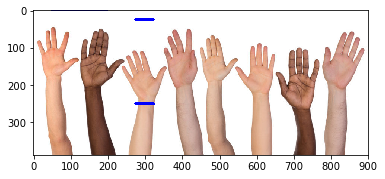

In [20]:
from scipy.ndimage.measurements import label

heatmap = np.zeros_like(testing_img[:, :, 0]).astype(np.float)
print(heatmap.shape)

for box in on_windows:
    print('Adding heat to box: {}'.format(box))
    # Add += 1 for all pixels inside each bbox
    # Assuming each "box" takes the form ((x1, y1), (x2, y2))
    heatmap[box[0][0]:box[1][0], box[0][1]:box[1][1]] += 1

heatmap[heatmap <= 2] = 0
heatmap = np.clip(heatmap, 0, 255)
labels, num_features = label(heatmap)
print(labels.shape)
print(num_features)

testing = testing_img.copy()

bbox_list = []
for label_number in range(1, num_features+1):
    nonzero_index = (labels == label_number).nonzero()
    # Identify x and y values of those pixels
    nonzero_y = np.array(nonzero_index[0])
    nonzero_x = np.array(nonzero_index[1])
    # Define a bounding box based on min/max x and y
    min_nonzero_x = np.min(nonzero_x)
    print(min_nonzero_x)
    min_nonzero_y = np.min(nonzero_y)
    print(min_nonzero_y)
    max_nonzero_x = np.max(nonzero_x)
    print(max_nonzero_x)
    max_nonzero_y = np.min(nonzero_y)
    print(max_nonzero_y)
    bbox = ((min_nonzero_x, min_nonzero_y),
            (max_nonzero_x, max_nonzero_y))
    bbox_list.append(bbox)
        # Draw the box on the image
    cv2.rectangle(testing, bbox[0], bbox[1], (0, 0, 255), 6)
    
print(bbox_list)
plt.imshow(testing)
plt.show()